# <b>1.  Load the Model and Processor</b>

In [1]:
from transformers import CLIPModel, CLIPProcessor, TrainingArguments, Trainer
import torch
import pandas as pd
import random
from PIL import Image
from torch.utils.data import Dataset
from datetime import datetime

# Set seed
random.seed(42)

In [2]:
# Setting up PyTorch to use my 2nd GPU.
if torch.cuda.is_available() and (torch.cuda.device_count() > 1):
    device = torch.device("cuda:1")
else:
    device = torch.device("cpu")
device

device(type='cuda', index=1)

In [18]:
device = torch.device("cpu")
device

device(type='cpu')

In [4]:
model_name = "flax-community/clip-rsicd-v2"
model = CLIPModel.from_pretrained(model_name).to(device)
processor = CLIPProcessor.from_pretrained(model_name)


# <b>2. Load the training and validation Datasets</b>
## <b>2.1. Load the training dataset</b>

In [5]:
# Load the test dataset into a Pandas dataframe.
trainingDataDataframe = pd.read_csv('train.csv')
## Confirm if the dataframe was loaded succesfully by printing the first 3 rows of the dataframe.
trainingDataDataframe.head(3)

,Image Name,Caption,File Path
0,agricultural00,"a photo with agricultural field, trees",.\DLRSD\Images\agricultural\agricultural00.tif
1,agricultural02,a photo with agricultural field,.\DLRSD\Images\agricultural\agricultural02.tif
2,agricultural03,a photo with agricultural field,.\DLRSD\Images\agricultural\agricultural03.tif


In [6]:
trainingDataDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Name  1680 non-null   object
 1   Caption     1680 non-null   object
 2   File Path   1680 non-null   object
dtypes: object(3)
memory usage: 39.5+ KB


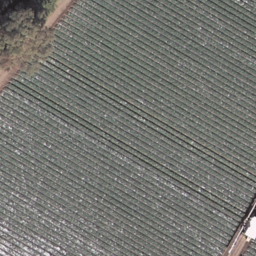

In [7]:
# Check if images are accessible for this notebook by printing any image.
image = Image.open(trainingDataDataframe['File Path'][0])
image

In [8]:
print("Image shape: ", image.size)

Image shape:  (256, 256)


In [9]:
# Create a pytorch Dataset class for Training data
class TrainingDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['File Path'][index]
        image = Image.open(image_path).convert("RGB")
        caption = self.dataframe['Caption'][index]
        preprocessedIImageCaptionInput = self.processor(
            text=caption,
            images=image,
            return_tensors="pt",
            padding=True
            ).to(device)
        return preprocessedIImageCaptionInput
    
trainingDataset = TrainingDataset(trainingDataDataframe, processor)
trainingDataset

In [10]:
len(trainingDataset)

1680

## <b>2.2. Load the validation dataset</b>

In [11]:
# Load the validation dataset into a Pandas dataframe.
validationDataDataframe = pd.read_csv('test.csv')
## Confirm if the dataframe was loaded succesfully by printing the first 3 rows of the dataframe.
validationDataDataframe.head(3)

,Image Name,Caption,File Path
0,agricultural01,a photo with agricultural field,.\DLRSD\Images\agricultural\agricultural01.tif
1,agricultural04,a photo with trees,.\DLRSD\Images\agricultural\agricultural04.tif
2,agricultural06,a photo with agricultural field,.\DLRSD\Images\agricultural\agricultural06.tif


In [12]:
validationDataDataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Image Name  420 non-null    object
 1   Caption     420 non-null    object
 2   File Path   420 non-null    object
dtypes: object(3)
memory usage: 10.0+ KB


In [13]:
# Create a pytorch Dataset class for validation data
class validationDataset(Dataset):
    def __init__(self, dataframe, processor):
        self.dataframe = dataframe
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['File Path'][index]
        image = Image.open(image_path).convert("RGB")
        caption = self.dataframe['Caption'][index]
        preprocessedIImageCaptionInput = self.processor(
            text=caption,
            images=image,
            return_tensors="pt",
            padding=True
            ).to(device)
        return preprocessedIImageCaptionInput
    
validationDataset = validationDataset(validationDataDataframe, processor)
validationDataset

In [14]:
len(validationDataset)

420

# <b>3. Define the training arguments.</b>

In [16]:
BATCH_SIZE = 32
NUMBER_OF_EPOCHS = 1

training_args = TrainingArguments(
    output_dir = "./tmp/clip-rsid-model",
    overwrite_output_dir = False,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "steps",
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    gradient_accumulation_steps = 8,
    learning_rate = 5e-05,
    weight_decay = 0.1,
    adam_beta1 = 0.9,
    adam_beta2 = 0.98,
    adam_epsilon = 1e-06,
    max_grad_norm = 1.0,
    num_train_epochs = NUMBER_OF_EPOCHS,
    max_steps = -1,
    lr_scheduler_type = "linear",
    warmup_ratio = 0.2,
    # warmup_steps = 0,
    logging_first_step = False,
    logging_steps = 50,
    # eval_strategy="epoch",
    eval_steps = 200,
    save_strategy="epoch",
    seed = 42,
    dataloader_drop_last = False,
    run_name = None,
    adafactor = False,
    report_to = "all",
    skip_memory_metrics = True,
    load_best_model_at_end=False,
    push_to_hub=False,
    resume_from_checkpoint = None
)

d:\Tutorials\Python\AI\venv\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trainingDataset,
    eval_dataset=validationDataset,
    # tokenizer=tokenizer,
    # data_collator=data_collator,
    # compute_metrics=compute_metrics,
)


[codecarbon INFO @ 16:01:48] [setup] RAM Tracking...
[codecarbon INFO @ 16:01:48] [setup] GPU Tracking...
[codecarbon INFO @ 16:01:48] Tracking Nvidia GPU via pynvml


NVMLError_NotSupported: Not Supported

In [ ]:
trainer.train()


True